In [1]:
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load the data

In [2]:
data = pd.read_csv('us_census.csv', sep=",")
target = data['income']
data = data.drop(columns=['income'])

In [3]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [4]:
target_train.value_counts(normalize=True)

<=50K    0.761841
>50K     0.238159
Name: income, dtype: float64

## Preprocessing pipeline

In [5]:
numerical_columns = selector(dtype_exclude=object)(data)
categorical_columns = selector(dtype_include=object)(data)

In [6]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [7]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

## Create the fair model wrapper

In [8]:
class fairModelWrapper:
    
    def __init__(self, model):
        self.model = model

    def fit(self, data, target, plot=True):
        data_target = data.copy()
        data_target['predictions'] = self.model.predict(data)
        
        income_proba = data_target['predictions'].value_counts(normalize=True)['<=50K']
        
        female_predicted_probas = self.model.predict_proba(data_target[data_target['sex']=='Female'])[:,1]
        self.female_threshold = np.quantile(female_predicted_probas, income_proba)
        
        male_predicted_probas = self.model.predict_proba(data_target[data_target['sex']=='Male'])[:,1]
        self.male_threshold = np.quantile(male_predicted_probas, income_proba)
        
        if plot:
            df_probas_female = pd.DataFrame(female_predicted_probas, columns=['probas'])
            df_probas_female['sex'] = 'female'

            df_probas_male = pd.DataFrame(male_predicted_probas, columns=['probas'])
            df_probas_male['sex'] = 'male'

            df_probas = pd.concat((df_probas_female,df_probas_male), ignore_index=True)

            sns.histplot(data=df_probas, x='probas', hue='sex', bins=20, kde=True, palette='viridis', stat='percent')
            plt.axvline(self.female_threshold, 0,0.7, c='tab:blue')
            plt.axvline(self.male_threshold, 0,0.7, c='mediumseagreen')
            plt.xlabel('Predicted probability of having an income above 50K')
            plt.annotate('Threshold for females to \nbe predicted as high income',
                    xy =(0.63, 10), color='tab:green'
                )
            plt.annotate('Threshold for males to \nbe predicted as high income',
                    xy =(0., 23), color='tab:blue'
                )
            plt.ylim(0,30)
            plt.xlim(-0.05,1.3)
        
    
    def predict(self, data_test):
        data_target = data_test.copy()
        data_target['predictions'] = self.model.predict(data_test)
        
        female_predicted_probas = self.model.predict_proba(data_target[data_target['sex']=='Female'])[:,1]
        female_predictions_fair = np.where(female_predicted_probas>self.female_threshold, '>50K', '<=50K')
        
        male_predicted_probas = self.model.predict_proba(data_target[data_target['sex']=='Male'])[:,1]
        male_predictions_fair = np.where(male_predicted_probas>self.male_threshold, '>50K', '<=50K')
        
        data_target.loc[data_target['sex']=='Female', 'predictions'] = female_predictions_fair        
        data_target.loc[data_target['sex']=='Male', 'predictions'] = male_predictions_fair        
        return np.array(data_target['predictions'])
        
        
    def score(self, data, target):
        predictions = self.predict(data)
        return accuracy_score(predictions, target)


## Fit the model and wrap it

/Users/samuelcohen/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/samuelcohen/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


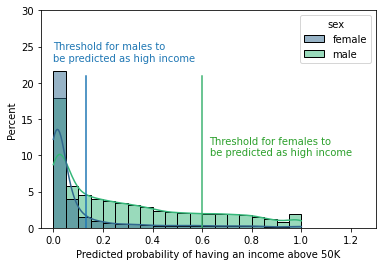

In [9]:
model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model.fit(data_train, target_train)
fairmodel = fairModelWrapper(model)
fairmodel.fit(data_train, target_train)

## Evaluate fairness and accuracy of the models

In [10]:
def compute_scores_and_plot_disparities(data_test, target_test, model):
    predictions_test = model.predict(data_test)
    
    tmp = data_test.copy()
    tmp['Model predictions'] = predictions_test
    tmp['Data'] = target_test
    
    grouped_predictions = tmp.groupby('sex')['Model predictions'].value_counts(normalize=True)
    dp_model = np.abs(grouped_predictions['Female']['>50K'] - grouped_predictions['Male']['>50K'])
    
    grouped_gt = tmp.groupby('sex')['Data'].value_counts(normalize=True)
    dp_data = np.abs(grouped_gt['Female']['>50K'] - grouped_gt['Male']['>50K'])
    
    fig, ax = plt.subplots(figsize=(6, 2))
    arguments = dict(data=tmp, x='Model predictions', hue='sex', kde=False, multiple="dodge", stat="percent", common_norm=False, discrete=True, shrink=.3, ax=ax, palette='viridis')
    sns.histplot(**arguments)
    ax.legend(handles=ax.legend_.legendHandles, labels=[t.get_text() for t in ax.legend_.texts],
              title=ax.legend_.get_title().get_text(),
              bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    
    fig, ax = plt.subplots(figsize=(6, 2))
    arguments = dict(data=tmp, x='Data', hue='sex', kde=False, multiple="dodge", stat="percent", common_norm=False, discrete=True, shrink=.3, ax=ax, palette='viridis')
    p = sns.histplot(**arguments)
    ax.legend(handles=ax.legend_.legendHandles, labels=[t.get_text() for t in ax.legend_.texts],
              title=ax.legend_.get_title().get_text(),
              bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()    
    
    print('\n','dp_model=%s\n'%dp_model, 'dp_data=%s\n'%dp_data, 'accuracy=%s'%model.score(data_test, target_test))

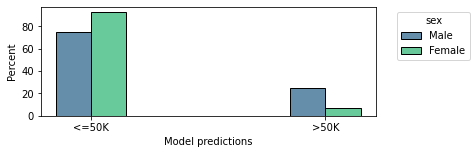

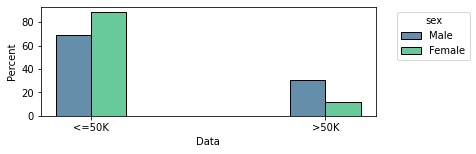


 dp_model=0.175768072280926
 dp_data=0.1920244613837473
 accuracy=0.8466956023257718


In [11]:
compute_scores_and_plot_disparities(data_test, target_test, model)

/Users/samuelcohen/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/samuelcohen/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


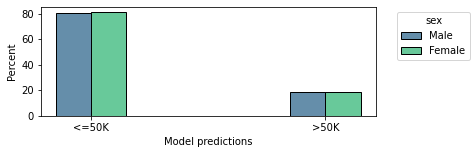

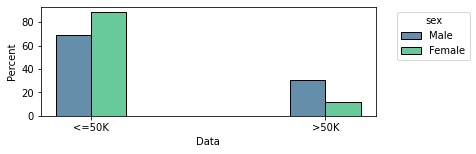


 dp_model=0.0019138844306005598
 dp_data=0.1920244613837473
 accuracy=0.8263860453689297


/Users/samuelcohen/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
/Users/samuelcohen/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [12]:
compute_scores_and_plot_disparities(data_test, target_test, fairmodel)